# Demonstration of FAE noise reduction capabilities

In this example we use a synth datset of blobs and heavily corrupted it using a binomial dropout noise (99%). We then recontruct the original dataset using an FAE

In [1]:
import pandas as pd
import torch
import numpy

import fiberedae.models.fae as vmod
import fiberedae.utils.basic_trainer as vtrain
import fiberedae.utils.persistence as vpers
import fiberedae.utils.single_cell as vsc
import fiberedae.utils.nn as vnnutils
import fiberedae.utils.plots as vplots
import fiberedae.utils.fae as vfae
import fiberedae.utils.datasets as vdatasets

import importlib

import fiberedae.utils.useful as us

import matplotlib.pyplot as plt

importlib.reload(vdatasets)

/home/tariq/miniconda3/envs/ml/lib/python3.7/site-packages/anndata-0.7.1-py3.7.egg/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


<module 'fiberedae.utils.datasets' from '/home/tariq/dev/py/ml/FiberedAE/fiberedae/utils/datasets.py'>

In [32]:
def pca(mat):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    return pca.fit_transform(mat)

def scatter_plot(mat_2d, targets):
    plt.scatter(mat_2d[:, 0], mat_2d[:, 1], c=targets, alpha=0.2, s=5)

def clean_data(model, samples, targets):
    return model.forward_output(x=samples, cond=targets)

In [53]:
config = us.load_configuration("configurations/blobs.json")

In [54]:
dataset = vdatasets.load_blobs(n_samples=5000,
                               nb_class=5,
                               nb_dim=128,
                               dropout_rate=0.99,
                               batch_size=config["hps"]["minibatch_size"],
                               mask_class=True)

## PCA of corrupted data
After corruption, we can see "fake" patterns appearing

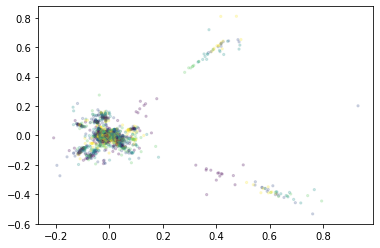

In [16]:
blobs_2d, targets = pca(dataset["datasets"]["train"]["samples"]), dataset["datasets"]["train"]["unmasked_targets"]
scatter_plot(blobs_2d, targets)

## PCA of clean data

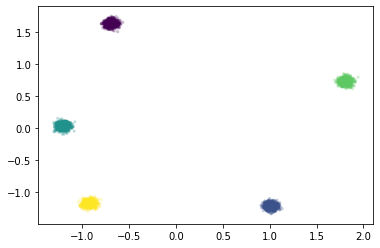

In [17]:
blobs_2d, targets = pca(dataset["datasets"]["train"]["clean_samples"]), dataset["datasets"]["train"]["unmasked_targets"]
scatter_plot(blobs_2d, targets)

## Training

In [117]:
config = us.load_configuration("configurations/blobs.json")

In [118]:
model_args = dict(config["model"])
model_args.update(
    dict(
        x_dim=dataset["shapes"]["input_size"],
        nb_class=dataset["shapes"]["nb_class"],
        output_transform=vnnutils.ScaleNonLinearity(-1., 1., dataset["sample_scale"][0], dataset["sample_scale"][1]),
    )
)
#make model
model = vmod.FiberedAE(**model_args)
model.to("cuda")


running on: cuda


In [121]:
#train model
trainer, history = us.train(model, dataset, config, nb_epochs=config["hps"]["nb_epochs"])

re: 0.1676,pr: 1.6148,cofige: 1.6136,gage: 0.9433,gadi: 0.5767: 100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


## PCA of FAE cleaned that
Some of the original structure is retrieved.

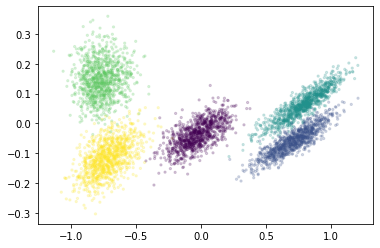

In [123]:
samples, targets = dataset["datasets"]["train"]["clean_samples"], dataset["datasets"]["train"]["unmasked_targets"]
samples, targets = torch.tensor(samples, dtype=torch.float).to("cuda"), torch.tensor(targets).to("cuda")
cleaned = model.forward_output(x=samples, cond=torch.zeros_like(targets)).cpu().detach().numpy()
scatter_plot(pca(cleaned), dataset["datasets"]["train"]["unmasked_targets"])